# start

from 0320_6; on gpubox

In [1]:
PRFX='0322_4'
trntmstmp=1584412344
valtmstmp=1584405047
import datetime
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)])

grand_total=1.5e8
MIN_TM_TRN=1580947200
MIN_TM_TST=1581552000
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (MIN_TM_TRN, MIN_TM_TST)])


['2020-03-17 02:32:24', '2020-03-17 00:30:47']
['2020-02-06 00:00:00', '2020-02-13 00:00:00']


# setup

In [ ]:
from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost as xgb
import dask_xgboost
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from dask.distributed import Client
import pickle
import lightgbm as lgb
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwng_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_fllwer_cnt',
'u2_fllwng_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)

dask.__version__ 2.12.0


# prepare data

## get maps from dfval

In [3]:
# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

In [4]:
def prp_df(df, istrn=True):
    tm_min = MIN_TM_TRN if istrn else MIN_TM_TST
    df['len_toks'] = df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)
    
    df['twt_age'] = df.tm - tm_min
    df['u1_age']  = df.tm - df.u1_create_tm
    df['u2_age']  = df.tm - df.u2_create_tm
        
    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_hour']=tm_dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

    for lang in langs:
        df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
        df.drop(inplace=True, columns=['hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', 'u2id', 'twtid', ]+cols_tgt_tmstmp, )
    else:
        df.drop(inplace=True, columns=['hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', ])        
    return df

In [5]:
grand_total

150000000.0

In [6]:
grand_total/1e6

150.0

In [7]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=1e6
                       )

np.random.seed(SEED)
lst_df = []
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk)
    print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') 
           for o in (df.tm.min(), df.tm.max())])
    df = prp_df(df)    
    lst_df.append(df)
    if ichnk>=0: break



2020-03-22 15:32:58 chunk 0


In [8]:
df = pd.concat(lst_df)

In [9]:
df.shape

(1000000, 96)

In [11]:
vec = TfidfVectorizer(ngram_range=(1,1),
                      min_df=100, max_df=0.5, 
                      strip_accents='unicode', use_idf=1,
                      smooth_idf=1, sublinear_tf=1)

In [14]:
%%time
Xtk = vec.fit_transform(df.toks)

In [15]:
Xtk.shape

(1000000, 23370)

In [16]:
%%time
Xtk=Xtk.toarray()

CPU times: user 18.4 s, sys: 1min 3s, total: 1min 21s
Wall time: 2min 7s


In [19]:
Xtk.shape

(1000000, 23370)

In [24]:
df.drop(columns=['toks'], inplace=True)

In [25]:
cols_feat=[o for o in df.columns if o not in cols_tgt]

In [26]:
X,y=df[cols_feat].values,df[cols_tgt ].values

In [30]:
cols_tk = [f't{i}' for i in range(Xtk.shape[1])]
len(cols_tk), cols_tk[:10]

(23370, ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9'])

In [31]:
cols_feat += cols_tk

In [ ]:
%%time
X=np.concatenate([X,Xtk],1)

In [ ]:
%%time
split=int(len(df)*0.85)
Xtr,Xvl=X[:split],X[split:]
ytr,yvl=y[:split],y[split:]

In [ ]:
Xtr.shape,Xvl.shape,ytr.shape,yvl.shape

In [ ]:
tgt2ytr={tgt:ytr[:,i] for i,tgt in enumerate(tgts)}
tgt2yvl={tgt:yvl[:,i] for i,tgt in enumerate(tgts)}

# model

In [17]:
tgt2bst={}
tgt2evalres={}

tgt2params = {k:{'objective': 'binary:logistic',
    'verbosity': 1,
    'eval_metric': ['aucpr', 'logloss', ],
} for k in tgts}
tgt2params

{'Retweet': {'objective': 'binary:logistic',
  'verbosity': 1,
  'eval_metric': ['aucpr', 'logloss']},
 'Reply': {'objective': 'binary:logistic',
  'verbosity': 1,
  'eval_metric': ['aucpr', 'logloss']},
 'Like': {'objective': 'binary:logistic',
  'verbosity': 1,
  'eval_metric': ['aucpr', 'logloss']},
 'RTwCmnt': {'objective': 'binary:logistic',
  'verbosity': 1,
  'eval_metric': ['aucpr', 'logloss']}}

In [19]:
def traintgt(tgt):
    evals_result = {}
    i=tgts.index(tgt)
    params = tgt2params[tgt]
    print(tgt, params)
    dtr = xgb.DMatrix(Xtr, label=tgt2ytr[tgt], feature_names=cols_feat)
    dvl = xgb.DMatrix(Xvl, label=tgt2yvl[tgt], feature_names=cols_feat)
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=1000, 
                    evals=evallist, evals_result=evals_result, 
                    verbose_eval=20,
                    early_stopping_rounds=50)
    tgt2bst[tgt] = bst
    tgt2evalres[tgt] = evals_result
    return bst,evals_result

In [20]:
tgts

['Retweet', 'Reply', 'Like', 'RTwCmnt']

In [ ]:
for i,tgt in enumerate(tgts):
    print(dtnow(), tgt, '*'*80)
    tgt2bst[tgt],tgt2evalres[tgt] = traintgt(tgt)
pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-22 15:19:55 Retweet ********************************************************************************
Retweet {'objective': 'binary:logistic', 'verbosity': 1, 'eval_metric': ['aucpr', 'logloss']}
[0]	train-aucpr:0.25822	train-logloss:0.53334	eval-aucpr:0.25622	eval-logloss:0.53337
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[20]	train-aucpr:0.31836	train-logloss:0.31108	eval-aucpr:0.30334	eval-logloss:0.31477
[40]	train-aucpr:0.33502	train-logloss:0.30614	eval-aucpr:0.31123	eval-logloss:0.31214
[60]	train-aucpr:0.34519	train-logloss:0.30325	eval-aucpr:0.31435	eval-logloss:0.31100
[80]	train-aucpr:0.35468	train-logloss:0.30102	eval-aucpr:0.31636	eval-logloss:0.31048
[100]	train-aucpr:0.36190	train-logloss:0.29929	eval-aucpr:0.31705	eval-logloss:0.31025
[120]	train-aucpr:0.37242	train-logloss:0.29687	eval-aucpr:0.31701	eval-logloss:0.31018
[140]	train-aucpr:0.37963	train-loglos

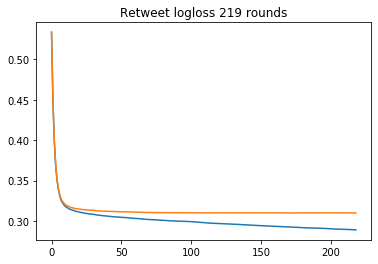

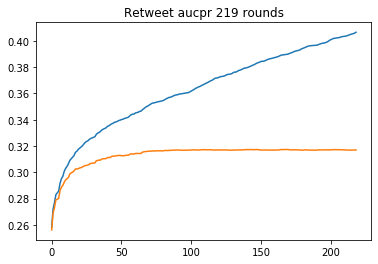

In [26]:
for tgt in tgt2evalres:
    evalres=tgt2evalres[tgt]
    plt.plot(evalres['train']['logloss'])
    plt.plot(evalres['eval']['logloss'])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()
    plt.plot(evalres['train']['aucpr'])
    plt.plot(evalres['eval']['aucpr'])
    plt.title(f"{tgt} aucpr {len(evalres['train']['aucpr'])} rounds")
    plt.show()

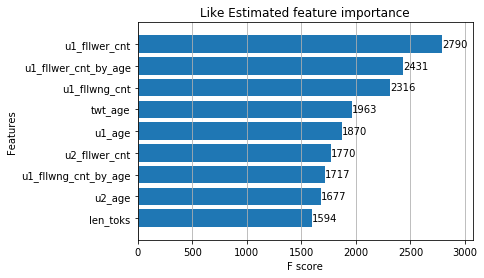

Like


,0,1
5,u1_fllwer_cnt,2790
4,u1_fllwer_cnt_by_age,2431
20,u1_fllwng_cnt,2316
14,twt_age,1963
6,u1_age,1870
11,u2_fllwer_cnt,1770
2,u1_fllwng_cnt_by_age,1717
8,u2_age,1677
3,len_toks,1594
13,u2_fllwng_cnt,1539


In [45]:
def show_feat_importance(tgt):
    bst=tgt2bst[tgt]
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title(f'{tgt} Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    print(tgt)
    display(pd.DataFrame([feat2importance.keys(), feat2importance.values()]).T.sort_values(1, ascending=False))

for tgt in tgt2bst:
    show_feat_importance(tgt)

## valid

In [35]:
def validtgt(tgt):
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    dtr = xgb.DMatrix(Xtr, label=tgt2ytr[tgt], feature_names=cols_feat)
    dvl = xgb.DMatrix(Xvl, label=tgt2yvl[tgt], feature_names=cols_feat)
    prdtr = bst.predict(dtr, ntree_limit=bst.best_ntree_limit)
    prdvl = bst.predict(dvl, ntree_limit=bst.best_ntree_limit)
    return prdtr,prdvl

In [36]:
tgt2prdtr={}
tgt2prdvl={}
for tgt,bst in tgt2bst.items():
    tgt2prdtr[tgt],tgt2prdvl[tgt]=validtgt(tgt)    

2020-03-22 15:12:41 Retweet


In [40]:
tgt2auc_trn={}
tgt2rce_trn={}
tgt2auc_val={}
tgt2rce_val={}
for tgt in tgt2bst:
    print(tgt)
    prdtr_i, prdvl_i = tgt2prdtr[tgt], tgt2prdvl[tgt]
    ytr_i, yvl_i = tgt2ytr[tgt], tgt2yvl[tgt]
    scr_auc_trn=compute_prauc(prdtr_i, ytr_i)
    scr_rce_trn=compute_rce(prdtr_i, ytr_i)
    scr_auc_val=compute_prauc(prdvl_i, yvl_i)
    scr_rce_val=compute_rce(prdvl_i, yvl_i)

    tgt2auc_trn[tgt]=scr_auc_trn
    tgt2rce_trn[tgt]=scr_rce_trn
    tgt2auc_val[tgt]=scr_auc_val
    tgt2rce_val[tgt]=scr_rce_val
    
    print('train prauc:', f'{scr_auc_trn:.4f}','train rce:', f'{scr_rce_trn:.4f}', )
    print('valid prauc:', f'{scr_auc_val:.4f}','valid rce:', f'{scr_rce_val:.4f}', )

Retweet
train prauc: 0.3898 train rce: 17.0056
valid prauc: 0.3174 valid rce: 12.3637


In [42]:
lsttrn=[]
lstval=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    if tgt not in tgt2bst: continue
    lsttrn+=[(f'PRAUC {tgt}',tgt2auc_trn[tgt]),
          (f'RCE {tgt}',tgt2rce_trn[tgt])]
    lstval+=[(f'PRAUC {tgt}',tgt2auc_val[tgt]),
          (f'RCE {tgt}',tgt2rce_val[tgt])]

dfscrtrn=pd.DataFrame(lsttrn)
dfscrtrn.columns=['metric','scr']
dfscrval=pd.DataFrame(lstval)
dfscrval.columns=['metric','scr']
dfscr = pd.merge(dfscrtrn, dfscrval, on='metric', suffixes=('trn','val'))
dfscr.T

,0,1
metric,PRAUC Retweet,RCE Retweet
scrtrn,0.389802,17.0056
scrval,0.317397,12.3637


# infer

In [22]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
#     f'{p_in}/val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv',
    sep='\x01', header=None, names=cols_val,)


CPU times: user 1min 37s, sys: 8.76 s, total: 1min 46s
Wall time: 1min 46s


In [23]:
%%time
dftst = prp_df(dftst, istrn=False)

CPU times: user 47.1 s, sys: 8.17 s, total: 55.3 s
Wall time: 55.3 s


In [24]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtst[tgt] = bst.predict(dtst)

2020-03-20 16:28:21 Retweet
2020-03-20 16:28:34 Reply
2020-03-20 16:28:39 Like
2020-03-20 16:29:33 RTwCmnt
CPU times: user 19min 49s, sys: 12.8 s, total: 20min 2s
Wall time: 1min 53s


In [25]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [26]:
%%time
for tgt, dfsub in tgt2dfsub.items():
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-20 16:29:38 Retweet
2020-03-20 16:30:34 Reply
2020-03-20 16:31:31 Like
2020-03-20 16:32:26 RTwCmnt
CPU times: user 3min 37s, sys: 6.78 s, total: 3min 44s
Wall time: 3min 45s
